In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
train = pd.read_csv("../data/raw/train(1).csv")
test = pd.read_csv("../data/raw/test2.csv")


### Basic Cleaning

In [2]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

for df in [train, test]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month


In [3]:
train.drop(columns=['date'], inplace=True)
test.drop(columns=['date'], inplace=True)


### FEATURE ENGINEERING

In [4]:
# Green Cover Proxies

train['green_density'] = train['sqft_lot15'] / train['sqft_living15']
test['green_density'] = test['sqft_lot15'] / test['sqft_living15']


In [5]:
# Neighborhood Density

train['neighborhood_density'] = train['sqft_living15'] / train['sqft_lot15']
test['neighborhood_density'] = test['sqft_living15'] / test['sqft_lot15']


In [6]:
# Visual Spaciousness Score

train['spaciousness_score'] = train['sqft_living'] / train['sqft_lot']
test['spaciousness_score'] = test['sqft_living'] / test['sqft_lot']


In [7]:
# Waterfront Interaction Feature

train['waterfront_lot_interaction'] = train['waterfront'] * train['sqft_lot']
test['waterfront_lot_interaction'] = test['waterfront'] * test['sqft_lot']


### Location Clusters (Urban vs Suburban)

In [8]:
from sklearn.cluster import KMeans

coords = train[['lat', 'long']]
kmeans = KMeans(n_clusters=5, random_state=42)

train['location_cluster'] = kmeans.fit_predict(coords)
test['location_cluster'] = kmeans.predict(test[['lat', 'long']])


In [9]:
# TARGET TRANSFORMATION

train['log_price'] = np.log1p(train['price'])


In [10]:
# Feature Selection for Model

features = [
    'bedrooms','bathrooms','sqft_living','sqft_lot','floors',
    'waterfront','view','condition','grade',
    'sqft_above','sqft_basement',
    'lat','long',
    'sqft_living15','sqft_lot15',
    'year','month',

    # Engineered visual proxies
    'green_density',
    'neighborhood_density',
    'spaciousness_score',
    'waterfront_lot_interaction',
    'location_cluster'
]

X = train[features]
y = train['log_price']


### Train–Validation Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Model Training (Strong Baseline)

In [12]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [13]:
# Evaluation

val_preds = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2 = r2_score(y_val, val_preds)

print("RMSE (log):", rmse)
print("R2:", r2)


RMSE (log): 0.1650758759194727
R2: 0.9012513849775071


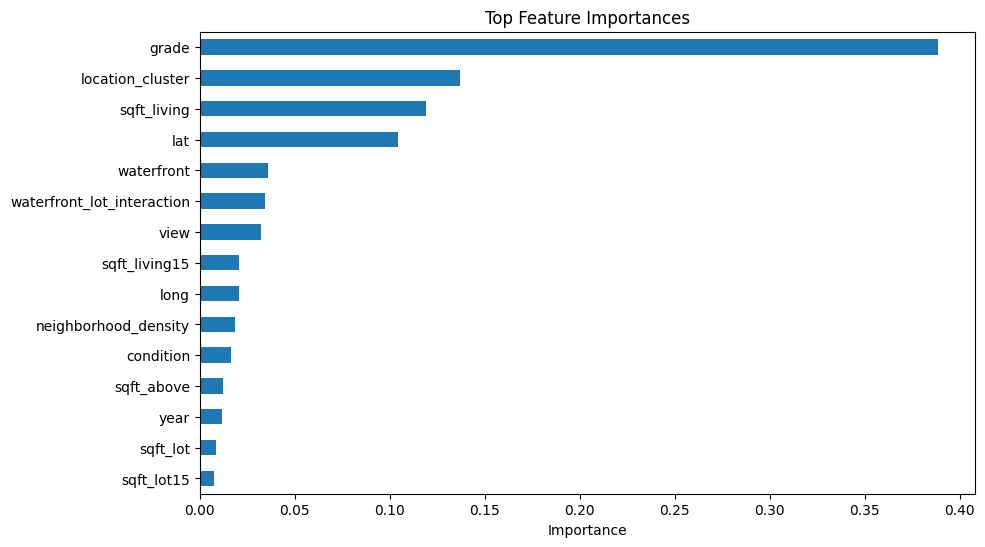

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Get correct feature names
feature_names = X_train.columns  # VERY IMPORTANT

# Create importance series
importance = pd.Series(
    model.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
importance.head(15).plot(kind="barh")
plt.title("Top Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


In [15]:
# Predict on Test Set

test_preds_log = model.predict(test[features])
test_preds = np.expm1(test_preds_log)

submission = pd.DataFrame({
    'id': test['id'],
    'predicted_price': test_preds
})

submission.to_csv("../outputs/predictions_tabular.csv", index=False)


### MODEL-1: TABULAR ONLY (BASELINE)

In [16]:
# Target
y = train["price"]

# Features
tabular_cols = [
    'bedrooms','bathrooms','sqft_living','sqft_lot',
    'floors','waterfront','view','condition','grade',
    'sqft_above','sqft_basement','yr_built','yr_renovated',
    'zipcode','lat','long','sqft_living15','sqft_lot15'
]

X_tab = train[tabular_cols]

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tab, y, test_size=0.2, random_state=42
)


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse_tab = np.sqrt(mse)  # RMSE


print("Tabular RMSE:", rmse_tab)


Tabular RMSE: 129287.64973490742


In [19]:
from sklearn.metrics import r2_score
r2_tab = r2_score(y_test, y_pred)
print("Tabular R²:", r2_tab)

Tabular R²: 0.8667982987944033


In [20]:
baseline_results = {
    "Model": "Tabular Only",
    "RMSE": rmse_tab,
    "R2": r2_tab
}


In [21]:
rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse_tab = np.sqrt(mse)
r2_tab = r2_score(y_test, y_pred)

print("Tabular RMSE:", rmse_tab)
print("Tabular R²:", r2_tab)


Tabular RMSE: 129287.64973490742
Tabular R²: 0.8667982987944033
